# Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Data load

In [4]:
sys.path.append(os.path.abspath(".."))
df = pd.read_csv("../data/nypd-motor-vehicle-collisions-cleaned.csv", low_memory=False)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217957 entries, 0 to 1217956
Data columns (total 29 columns):
 #   Column                         Non-Null Count    Dtype 
---  ------                         --------------    ----- 
 0   ACCIDENT DATE                  1217957 non-null  object
 1   ACCIDENT TIME                  1217957 non-null  object
 2   BOROUGH                        1217957 non-null  object
 3   LATITUDE                       1217957 non-null  object
 4   LONGITUDE                      1217957 non-null  object
 5   LOCATION                       1217957 non-null  object
 6   ON STREET NAME                 1217957 non-null  object
 7   CROSS STREET NAME              1217957 non-null  object
 8   OFF STREET NAME                1217957 non-null  object
 9   NUMBER OF PERSONS INJURED      1217957 non-null  int64 
 10  NUMBER OF PERSONS KILLED       1217957 non-null  int64 
 11  NUMBER OF PEDESTRIANS INJURED  1217957 non-null  int64 
 12  NUMBER OF PEDESTRIANS KILLED

# Most dangerous accident factors in each New York borough

In [6]:
df_factors = df.copy()

In [7]:
columns = ["BOROUGH","NUMBER OF PERSONS INJURED","NUMBER OF PERSONS KILLED","CONTRIBUTING FACTOR VEHICLE 1",
           "CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3","CONTRIBUTING FACTOR VEHICLE 4", 
           "CONTRIBUTING FACTOR VEHICLE 5", "COLLISION_ID"]

In [8]:
df_factors = df_factors[columns]

In [9]:
df_factors.head()

,BOROUGH,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID
0,QUEENS,0,0,passing too closely,unknown,unknown,unknown,unknown,4184637
1,BROOKLYN,0,0,passing too closely,unknown,unknown,unknown,unknown,4195773
2,MANHATTAN,1,0,driver inattention/distraction,unknown,unknown,unknown,unknown,4202457
3,BRONX,0,0,unknown,unknown,unknown,unknown,unknown,4198749
4,MANHATTAN,1,0,driver inattention/distraction,driver inattention/distraction,unknown,unknown,unknown,4183798


In [10]:
# https://pandas.pydata.org/docs/reference/api/pandas.melt.html

In [11]:
df_long = df_factors.melt(id_vars=["COLLISION_ID","BOROUGH","NUMBER OF PERSONS INJURED", "NUMBER OF PERSONS KILLED"], 
                         value_vars=["CONTRIBUTING FACTOR VEHICLE 1","CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3", 
               "CONTRIBUTING FACTOR VEHICLE 4","CONTRIBUTING FACTOR VEHICLE 5"],
                         var_name="FACTOR_SOURCE",
                         value_name="CONTRIBUTING FACTOR")

In [12]:
df_long.head()

,COLLISION_ID,BOROUGH,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,FACTOR_SOURCE,CONTRIBUTING FACTOR
0,4184637,QUEENS,0,0,CONTRIBUTING FACTOR VEHICLE 1,passing too closely
1,4195773,BROOKLYN,0,0,CONTRIBUTING FACTOR VEHICLE 1,passing too closely
2,4202457,MANHATTAN,1,0,CONTRIBUTING FACTOR VEHICLE 1,driver inattention/distraction
3,4198749,BRONX,0,0,CONTRIBUTING FACTOR VEHICLE 1,unknown
4,4183798,MANHATTAN,1,0,CONTRIBUTING FACTOR VEHICLE 1,driver inattention/distraction


In [13]:
df_long.duplicated().sum()

np.int64(0)

In [14]:
df_long["CONTRIBUTING FACTOR"].unique()

array(['passing too closely', 'driver inattention/distraction', 'unknown',
       'unsafe speed', 'reaction to uninvolved vehicle',
       'following too closely', 'passing or lane usage improper',
       'view obstructed/limited', 'unsafe lane changing',
       'aggressive driving/road rage', 'other vehicular',
       'driverless/runaway vehicle', 'turning improperly',
       'failure to yield right-of-way', 'backing unsafely',
       'brakes defective', 'drugs (illegal)', 'pavement defective',
       'traffic control disregarded', 'lane marking improper/inadequate',
       'tire failure/inadequate', 'failure to keep right',
       'obstruction/debris', 'outside car distraction',
       'alcohol involvement', 'driver inexperience', 'pavement slippery',
       'pedestrian/bicyclist/other pedestrian error/confusion',
       'using on board navigation device', 'lost consciousness',
       'passenger distraction', 'oversized vehicle', 'fatigued/drowsy',
       'illness', 'fell asleep', 's

In [15]:
df_long = df_long[
    ~df_long["BOROUGH"].isin(["UNKNOWN"]) &
    ~df_long["CONTRIBUTING FACTOR"].isin(["unknown"])
    ]

In [16]:
summary = df_long.groupby(["BOROUGH", "CONTRIBUTING FACTOR"]).agg(
    total_killed = ("NUMBER OF PERSONS KILLED", "sum"),
    total_injured = ("NUMBER OF PERSONS INJURED", "sum"),
    number_of_crashes = ("COLLISION_ID", "nunique")
).reset_index()

In [17]:
summary["total_impact"] = summary["total_killed"] + summary["total_injured"]

In [18]:
# https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html

In [19]:
impact_pivot = summary.pivot_table(
    index = "BOROUGH",
    columns = "CONTRIBUTING FACTOR",
    values = "total_impact",
    aggfunc = "sum"
)

In [20]:
top_factors = impact_pivot.sum().sort_values(ascending=False).head(5).index
impact_pivot = impact_pivot[top_factors]

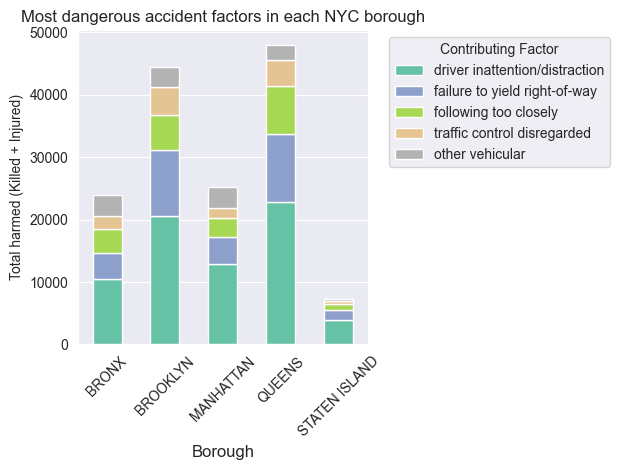

In [70]:
impact_pivot.plot(kind="bar", stacked=True, colormap="Set2")

plt.title("Most dangerous accident factors in each NYC borough", fontsize=12)
plt.xlabel("Borough", fontsize=12)
plt.xticks(rotation = 45)
plt.ylabel("Total harmed (Killed + Injured)")
plt.legend(title="Contributing Factor",bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(axis="x")
plt.show()

# How many deaths and injuries were caused by unsafe speed in each borough

In [22]:
df_speeding = df.copy()

In [23]:
columns = ["BOROUGH","NUMBER OF PERSONS INJURED","NUMBER OF PERSONS KILLED","CONTRIBUTING FACTOR VEHICLE 1",
           "CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3","CONTRIBUTING FACTOR VEHICLE 4", 
           "CONTRIBUTING FACTOR VEHICLE 5", "COLLISION_ID"]

In [24]:
df_speeding = df_speeding[columns]

In [25]:
df_speeding = df_speeding[~df_speeding["BOROUGH"].isin(["UNKNOWN"])]

In [26]:
df_long = df_speeding.melt(id_vars = ["COLLISION_ID","BOROUGH","NUMBER OF PERSONS INJURED", "NUMBER OF PERSONS KILLED"],
                          value_vars = ["CONTRIBUTING FACTOR VEHICLE 1","CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3", 
               "CONTRIBUTING FACTOR VEHICLE 4","CONTRIBUTING FACTOR VEHICLE 5"],
                         var_name="FACTOR_SOURCE",
                         value_name="CONTRIBUTING FACTOR")

In [27]:
df_long = df_long[df_long["CONTRIBUTING FACTOR"].isin(["unsafe speed"])]

In [28]:
summary = df_long.groupby(["BOROUGH"]).agg(
    total_killed = ("NUMBER OF PERSONS KILLED", "sum"),
    total_injured = ("NUMBER OF PERSONS INJURED", "sum")
).reset_index()

In [29]:
print(summary)

         BOROUGH  total_killed  total_injured
0          BRONX            18           1627
1       BROOKLYN            23           2211
2      MANHATTAN            10            750
3         QUEENS            48           2406
4  STATEN ISLAND            12            444


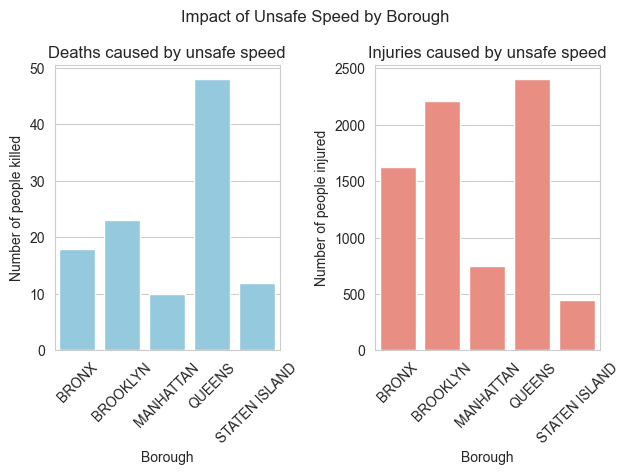

In [30]:
sns.set_style(style="whitegrid")

fig, axes = plt.subplots(1, 2)

sns.barplot(ax = axes[0], data = summary, x = "BOROUGH", y = "total_killed", color = "skyblue")
axes[0].set_title("Deaths caused by unsafe speed")
axes[0].set_xlabel("Borough")
axes[0].set_ylabel("Number of people killed")
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(ax=axes[1], data=summary, x="BOROUGH", y="total_injured", color="salmon")
axes[1].set_title("Injuries caused by unsafe speed")
axes[1].set_xlabel("Borough")
axes[1].set_ylabel("Number of people injured")
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle("Impact of Unsafe Speed by Borough")
plt.tight_layout()
plt.show()

# 3 most common accident factors broken down by borough and overall for the entire city

In [31]:
df_common_factors = df.copy()

In [32]:
columns = ["BOROUGH","CONTRIBUTING FACTOR VEHICLE 1","CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3","CONTRIBUTING FACTOR VEHICLE 4", 
           "CONTRIBUTING FACTOR VEHICLE 5"]

In [33]:
df_common_factors = df_common_factors[columns]

In [34]:
df_long = df_common_factors.melt(id_vars = ["BOROUGH"],
                                value_vars = ["CONTRIBUTING FACTOR VEHICLE 1","CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3",
                                              "CONTRIBUTING FACTOR VEHICLE 4","CONTRIBUTING FACTOR VEHICLE 5"],
                                 var_name = "FACTOR_SOURCE",
                                 value_name = "CONTRIBUTING FACTOR"
                                )

In [35]:
df_long = df_long[~df_long["CONTRIBUTING FACTOR"].isin(["unknown"])]

In [36]:
df_borough = df_long[
    ~df_long["BOROUGH"].isin(["UNKNOWN"]) &
    ~df_long["CONTRIBUTING FACTOR"].isin(["unknown"])
    ]

In [37]:
top_by_borough = df_borough.groupby(
    ["BOROUGH","CONTRIBUTING FACTOR"]).size().reset_index().rename(columns={0: 'count'}).sort_values(['BOROUGH', 'count'], ascending=[True, False])

In [38]:
top_3_by_borough = top_by_borough.groupby("BOROUGH").head(3)

In [54]:
pivot_borough = top_3_by_borough.pivot(index='BOROUGH', columns='CONTRIBUTING FACTOR', values='count')

In [68]:
top_3_entire = df_long["CONTRIBUTING FACTOR"].value_counts().head(3).reset_index()
top_3_entire.columns = ['CONTRIBUTING FACTOR', 'count']

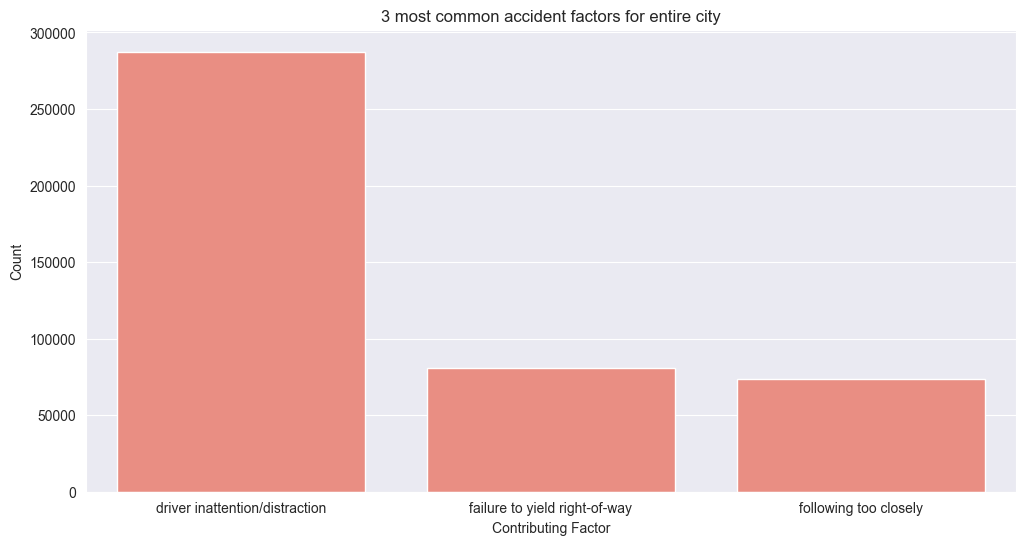

In [79]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(data = top_3_entire, x = "CONTRIBUTING FACTOR", y = "count", color = "salmon"  )
ax.set_title("3 most common accident factors for entire city")
ax.set_xlabel("Contributing Factor")
ax.set_ylabel("Count")
plt.show()

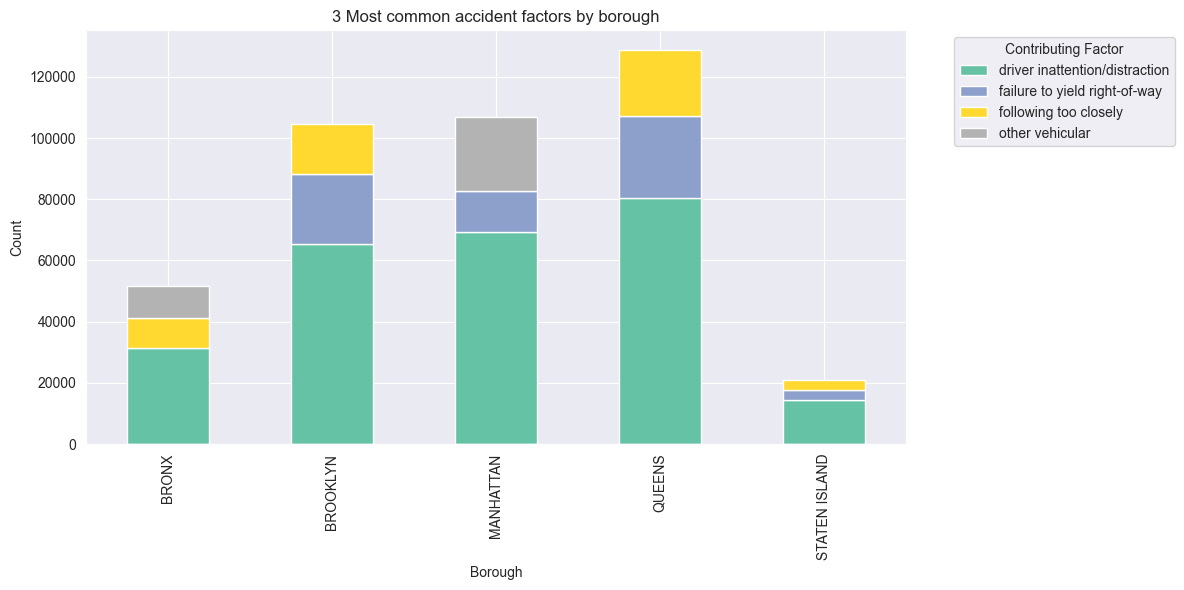

In [80]:
pivot_borough.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')

plt.title("3 Most common accident factors by borough")
plt.xlabel("Borough")
plt.ylabel("Count")
plt.legend(title="Contributing Factor", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Most frequently vehicles types involved in accidents

# Statistics on the number of accidents for each borough

# Most common accident locations (optional)